In [1]:
import tqdm
import json
import pandas as pd
import requests

SHEET_ID = '1b6h2RApBs2xbN6-eGVvxH68EALKDklvS91fb7d_IVz4'
SHEET_TABS = {
    'REGISTROS': 2103959160,
    'USUARIOS': 102021014,
}
REGISTROS_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TABS["REGISTROS"]}'
USUARIOS_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TABS["USUARIOS"]}'

In [2]:
# Empezamos cargando todos los datos (los usuarios y los mapas estan en dos tablas distintas)
df_registros = pd.read_csv(REGISTROS_URL)
df_registros.drop("Timestamp", axis=1, inplace=True)
df_registros.dropna(inplace=True, how="any")
display(df_registros.sample(3))

df_usuarios = pd.read_csv(USUARIOS_URL)
df_usuarios.drop("Timestamp", axis=1, inplace=True)
df_usuarios.dropna(inplace=True, how="all")
display(df_usuarios.sample(3))

,Padron,Carrera,Mapa
815,105138,industrial,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""81.0..."
857,109560,industrial,"{""materias"":[{""id"":""CBC24"",""nota"":10},{""id"":""C..."
1178,200793,informatica,"{""materias"":[{""id"":""CBC28"",""nota"":10},{""id"":""C..."


,Padron,Carrera,Orientacion,Final de Carrera
4944,105260,sistemas,NaN,NaN
9596,106768,sistemas,NaN,NaN
11379,104706,petroleo,NaN,NaN


In [3]:
### Testing purposes: en vez de laburar con toooodos los datos, laburemos solo con sistemas+informatica
# Comenta esta linea para que todo ande muchísimo más lento
df_usuarios = df_usuarios[df_usuarios['Carrera'].isin(['informatica'])]#, 'sistemas'])]

# Aún más testing?? Solo los integrantes del grupo
# df_usuarios = df_usuarios[df_usuarios['Padron'].isin(["100029", "101696", "101109", "0000"])]

In [4]:
# Mergeamos!
df_mergeado = df_usuarios.merge(df_registros)
df_mergeado.sample(3)

,Padron,Carrera,Orientacion,Final de Carrera,Mapa
396,103954,informatica,Sistemas Distribuidos,tpp,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."
843,101362,informatica,NaN,NaN,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""75.4..."
676,102831,informatica,NaN,NaN,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."


In [5]:
df_mergeado.describe()

,Padron,Carrera,Orientacion,Final de Carrera,Mapa
count,947,947,546,559,947
unique,947,1,3,2,846
top,107404,informatica,Sistemas Distribuidos,tpp,"{""materias"":[{""id"":""CBC"",""nota"":0,""cuatri"":-1}..."
freq,1,947,275,431,39


In [6]:
# Ahora, desempaquetamos la columna "Mapa" (un JSON que contiene notas, metadata, de todo...) 
#   y finalmente lleguemos al df que vamos a usar durante todo el tp

df = df_mergeado
new_df = pd.DataFrame()
for idx in tqdm.tqdm(df.index):
    json_mapa = json.loads(df.loc[idx]['Mapa'])
    
    for k in json_mapa.keys():
        if not json_mapa[k]: continue
        if k == "materias":
            # TODOs:
            # - ver si podemos migrar el legacy "materia_cuatri" con el nuevo "materia_cuatrimestre"
            df_json = pd.json_normalize(json_mapa, k, record_prefix="materia_")
        else:
            df_json = pd.DataFrame({k: [json_mapa[k]]})
        df_json["Padron"] = df.loc[idx]['Padron']
        new_df = pd.concat([new_df, df_json])

df = df.merge(new_df, how="outer")
df.drop('Mapa', axis=1, inplace=True)
df.sample(3)

100%|████████████████████████████████████████| 947/947 [00:02<00:00, 342.00it/s]


,Padron,Carrera,Orientacion,Final de Carrera,materia_id,materia_nota,materia_cuatrimestre,optativas,aplazos,materia_cuatri
16539,109220,informatica,NaN,NaN,CBC27,5.0,NaN,NaN,NaN,NaN
18747,5es5,informatica,Sistemas Distribuidos,tesis,61.08,4.0,NaN,NaN,NaN,-1.0
16488,92111,informatica,Gestión Industrial de Sistemas,tpp,62.15,4.0,NaN,NaN,NaN,-1.0


In [7]:
# Vamos a armar un grafazo: 
# nodos -> usuarios
# flechas -> cursar misma materia mismo cuatri
# TODO: peso de flechas -> correlacion entre notas(???)

df_nodes_metadata = df[["Padron", "Carrera", "aplazos", "optativas"]]#, "checkboxes"]]
df_nodes_metadata = df_nodes_metadata[df_nodes_metadata["aplazos"].notnull() | df_nodes_metadata["optativas"].notnull()]
df_nodes_metadata = df_nodes_metadata.groupby(["Padron", "Carrera"], as_index=False).first()

# TODO: hay un problemon con esto que es que explota cuando un usuario tiene mas de una carrera
# preguntarle a fede
df_nodes = df[["Padron", "Carrera", "Orientacion", "Final de Carrera"]]
df_nodes = df_nodes.drop_duplicates()
df_nodes = df_nodes.merge(df_nodes_metadata, how="outer")
df_nodes.set_index("Padron", inplace=True)
display(df_nodes.sample(3))

from itertools import combinations
df_edges = (df[df['materia_cuatrimestre'].notnull()]
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

df_edges = df_edges.reset_index()
df_edges[['src', 'dst']] = df_edges['Usuarios'].tolist()
df_edges[['src_padron', 'src_nota']] = df_edges['src'].tolist()
df_edges[['dst_padron', 'dst_nota']] = df_edges['dst'].tolist()
df_edges = df_edges[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]
display(df_edges.sample(3))

,Carrera,Orientacion,Final de Carrera,aplazos,optativas
Padron,,,,,
99616,informatica,Sistemas Distribuidos,tpp,NaN,NaN
104286,informatica,Sistemas de Producción,tesis,NaN,NaN
1999999,informatica,NaN,NaN,NaN,NaN


/tmp/ipykernel_69492/4001515465.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


,src_padron,dst_padron,materia_cuatrimestre,materia_id,src_nota,dst_nota
62603,100016,100517,2020.0,75.08,8.0,9.0
5628,102396,101698,2020.5,61.03,5.0,9.0
95626,96728,100839,2018.5,75.40,10.0,10.0


In [8]:
import networkx as nx
G = nx.from_pandas_edgelist(df_edges, 
                            source='src_padron', 
                            target='dst_padron', 
                            edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], 
                            create_using=nx.MultiGraph())

nx.set_node_attributes(G, df_nodes.to_dict('index'))
print(G)

MultiGraph with 383 nodes and 129715 edges


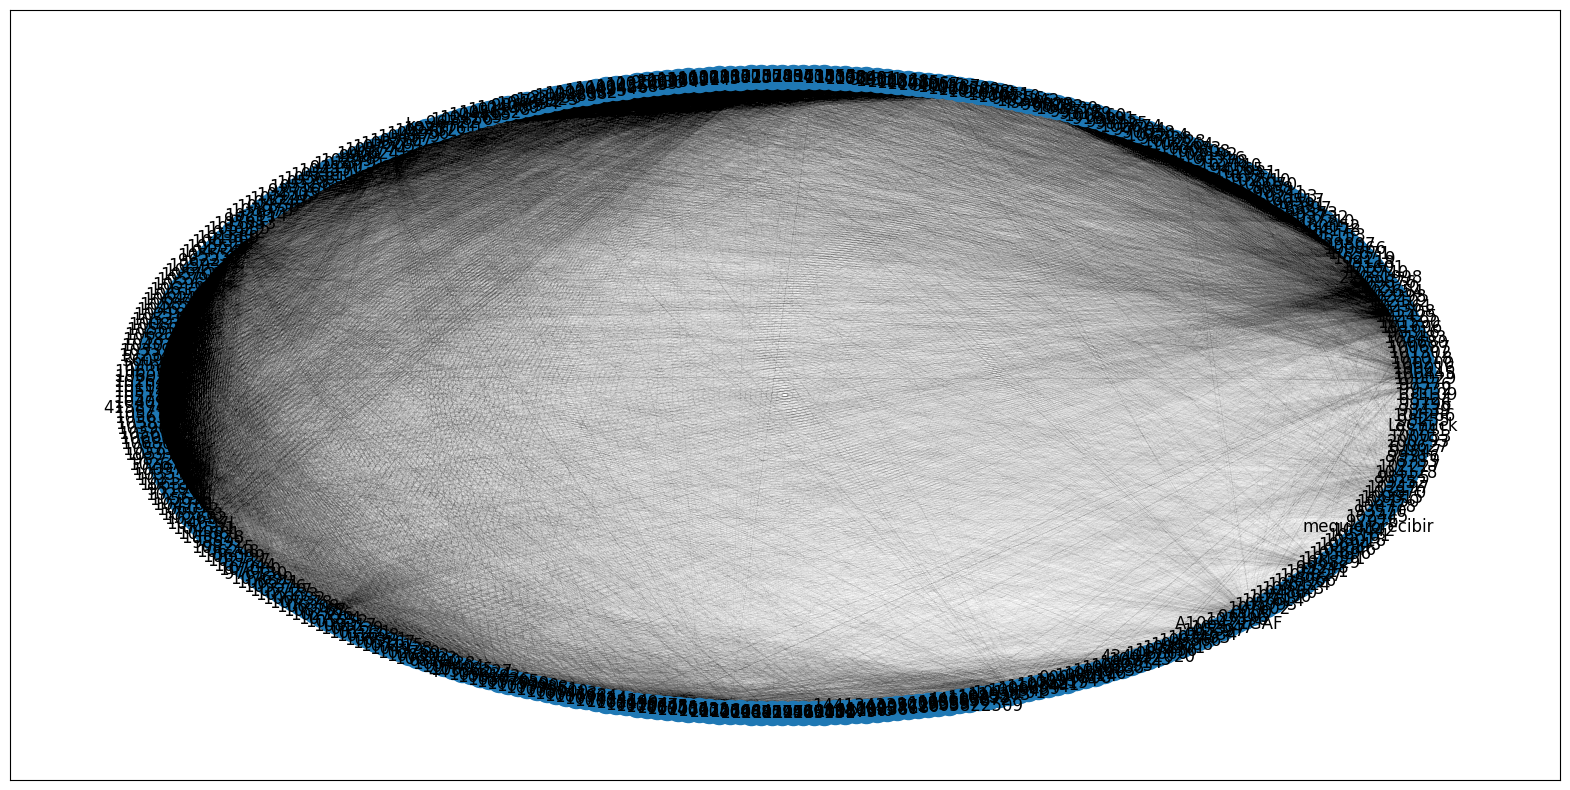

In [9]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.circular_layout(G), width=0.005)

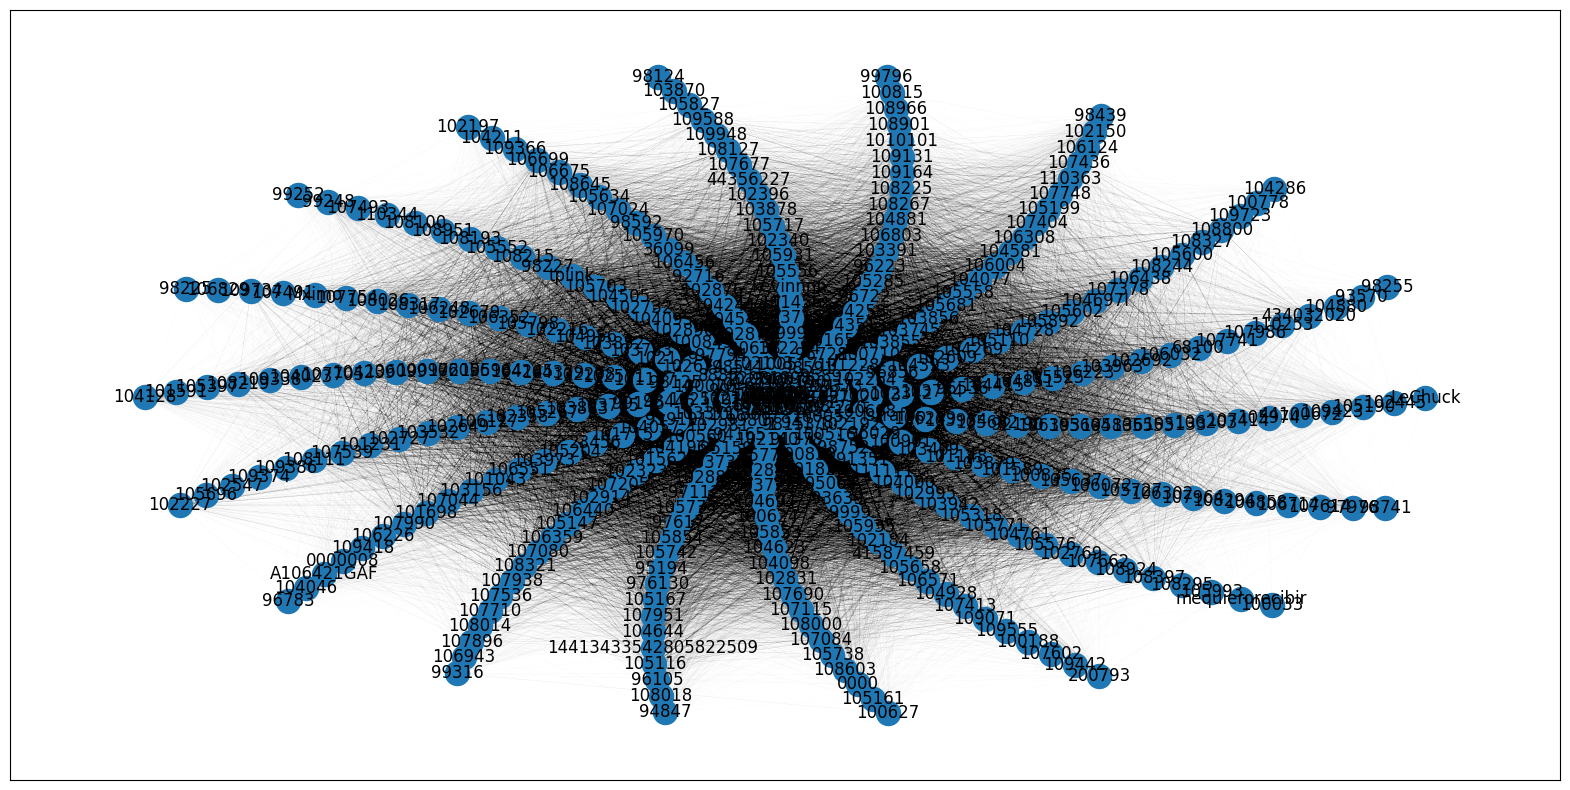

In [10]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.spiral_layout(G), width=0.005)

In [ ]:
# # Solo como demo: ahora veamos el grafo, pero dibujemos todas las aristas
# # Robadisimo de: https://stackoverflow.com/a/60638452
# pos = nx.random_layout(G)
# nx.draw_networkx_nodes(G, pos)
# ax = plt.gca()
# for e in G.edges:
#     ax.annotate("",
#                 xy=pos[e[0]], xycoords='data',
#                 xytext=pos[e[1]], textcoords='data',
#                 arrowprops=dict(arrowstyle="-", color="0.5",
#                                 connectionstyle="arc3,rad=rr".replace('rr',str(0.3*e[2]))),
#                 )
# plt.axis('off')
# plt.show()

In [12]:
### Hasta acá refactorizo Fede

In [13]:
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")



  El diámetro de la red: 4
  El grado promedio de la red: 677.36
  TODO: Los allegados promedio de la red: 
  Puentes globales: [('98439', '99796')]



In [14]:
from networkx.algorithms import community
louvain = community.louvain_communities(G)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
for louvaincommunity, color in zip(louvain, colors):
    draw_nodes.update({n: color for n in louvaincommunity})
    
plt.title("Louvain Communities")
nx.draw_networkx(G, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(G),
                 font_size=10)

In [ ]:
# Todo: sacar distribucion de padrones de cada comunidad, para poder clasificar
# as in "esta es la comunidad de los jovenes, esta es la de los viejos, esta no tiene patron, etc"
louvain

In [ ]:
subnetwork = nx.subgraph(G, max(louvain, key=len))
subnetwork_louvain = community.louvain_communities(subnetwork)
plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
for louvain, color in zip(subnetwork_louvain, colors):
    draw_nodes.update({n: color for n in louvain})
    
plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
nx.draw_networkx(subnetwork, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(subnetwork),
                 font_size=10)

In [ ]:
subnetwork_louvain

In [ ]:
# todo: usar graphrole y rolx

In [ ]:
# todo: ejercicio 5 de parcialito 3

In [ ]:
# todo: leer TODA la documentacion de "algorithms" de nx y ver que aplica aca
# https://networkx.org/documentation/stable/reference/algorithms/index.html

In [ ]:
# todo: plantear preguntas y resolverlas con comunidades:
# "que electivas curso?"
# "que cuatrimestre armo?"